📘 Hypothesis Test: Do Stock Prices Fall After a Data Breach?

Hypothesis:

“Stock prices will fall after a data breach.”

Plan:

Load dataset of stock prices + breach months.

Convert month–year strings to real dates.

Ensure one breach per organisation (keep earliest breach for companies with multiple breaches, e.g., Nintendo, Twitter, Uber).

Align stock prices by breach month (month_offset = 0).

Compute % change relative to breach month.

Produce a heatmap (red = fall, green = rise).

In [103]:
# ===============================================================
# 1) Load and parse dataset
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (adjust path if needed)
CSV_PATH = "merged_data_stocks_full.csv"
df = pd.read_csv(CSV_PATH)

# Parse month-year strings into datetime
df["stock_date"]  = pd.to_datetime(df["stock_month_year"],  format="%B %Y", errors="coerce")
df["breach_date"] = pd.to_datetime(df["breach_month_year"], format="%B %Y", errors="coerce")


Ensuring one breach per company

Some companies (e.g., Nintendo, Twitter, Uber) may have multiple breaches recorded.
To compare fairly, we need only one breach per organisation.

We choose the earliest breach date for each company and drop any others.

In [104]:
# ===============================================================
# 2) Enforce one breach per organisation
# ===============================================================

# Keep only the earliest breach per organisation
breaches_unique = (
    df.loc[~df["breach_date"].isna(), ["organisation","breach_date"]]
      .groupby("organisation", as_index=False)["breach_date"]
      .min()
)

# Merge unique breaches back to all stock rows
df = df.drop(columns=["breach_date"]).merge(breaches_unique, on="organisation", how="left")

# Safety check: confirm one breach per company
check_counts = df.dropna(subset=["breach_date"]).groupby("organisation")["breach_date"].nunique()
if (check_counts > 1).any():
    raise ValueError("Some organisations still have multiple breach months:\n" +
                     str(check_counts[check_counts > 1]))


Aligning stock prices by breach month

We compute the difference in months between each stock price record and the company’s breach month:

month_offset = 0 → breach month

−1, −2, −3 → before breach

+1, +2, +3 → after breach

We then restrict the analysis to the 7-month window (−3…+3).

In [105]:
# ===============================================================
# 3) Compute month offsets and filter window
# ===============================================================

df["month_offset"] = (
    (df["stock_date"].dt.year  - df["breach_date"].dt.year)  * 12 +
    (df["stock_date"].dt.month - df["breach_date"].dt.month)
)

# Focus on 7 months around breach
window = df[df["month_offset"].between(-3, 3)].copy()


Computing % change relative to breach month

We take the stock price at breach month (month_offset = 0) as the baseline (base_price).
Then calculate % change:

pct_change
=
100
×
monthly_average
−
base_price
base_price
pct_change=100×
base_price
monthly_average−base_price
	​


Positive → stock rose

Negative → stock fell

If duplicates exist for the same (organisation, month_offset), we take the average.

In [106]:
# ===============================================================
# 4) Baseline and % change
# ===============================================================

# Baseline (breach-month price per organisation)
base = (
    window.loc[window["month_offset"].eq(0), ["organisation","monthly_average"]]
          .drop_duplicates()
          .rename(columns={"monthly_average":"base_price"})
)

# Attach baseline to each row
window = window.merge(base, on="organisation", how="left")

# Compute % difference
window["pct_change"] = 100 * (window["monthly_average"] - window["base_price"]) / window["base_price"]

# Collapse duplicates
collapsed = (
    window.groupby(["organisation","month_offset"], as_index=False)
          .agg(monthly_average=("monthly_average","mean"),
               pct_change=("pct_change","mean"))
)


Heatmap of % changes

We pivot into a matrix:

Rows = month offsets (−3…+3)

Columns = organisations

Values = % change relative to breach month

Color scheme:

Red = stock fell (negative %)

Green = stock rose (positive %)

Scale is centered at 0.

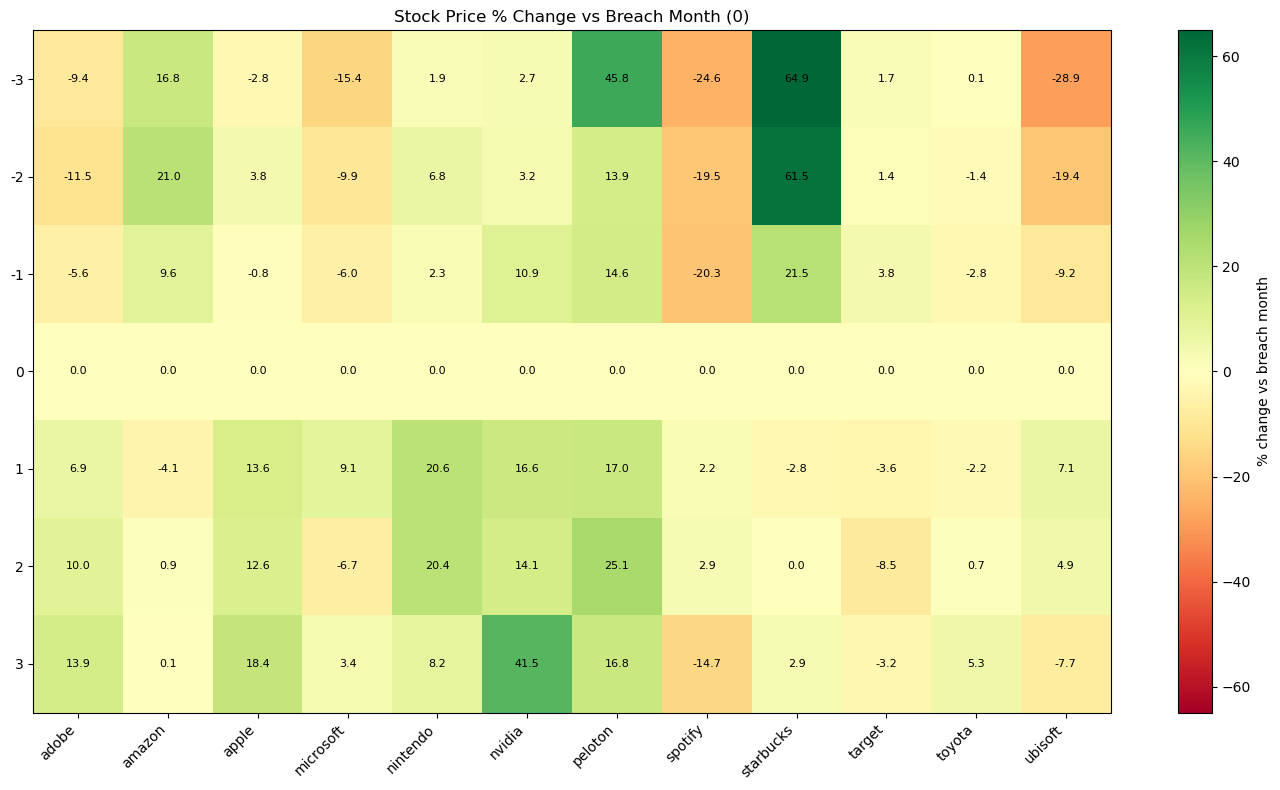

In [107]:
# ===============================================================
# 5) Heatmap of stock % change vs breach month
# ===============================================================

heatmap_data = (
    collapsed.pivot(index="month_offset", columns="organisation", values="pct_change")
             .sort_index()
)

def heatmap_with_annotations(data, title):
    fig, ax = plt.subplots(figsize=(14,8))
    
    vmax = np.nanmax(np.abs(data.values))
    im = ax.imshow(data.values, aspect="auto", cmap="RdYlGn", vmin=-vmax, vmax=vmax)
    
    ax.set_xticks(range(data.shape[1]))
    ax.set_xticklabels(list(data.columns), rotation=45, ha="right")
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels(list(data.index))
    ax.set_title(title)
    
    # Annotate cells
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data.values[i, j]
            txt = "" if np.isnan(val) else f"{val:.1f}"
            ax.text(j, i, txt, ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax, label="% change vs breach month")
    plt.tight_layout()
    plt.show()

heatmap_with_annotations(heatmap_data, "Stock Price % Change vs Breach Month (0)")


Aggregate statistics

To evaluate the hypothesis:

Compute the average % change across all companies for each offset.

Count how many companies are up vs down at +1 and +3 months.

In [108]:
# ===============================================================
# 6) Aggregate statistics
# ===============================================================

# Average % change across organisations at each offset
avg_change = heatmap_data.mean(axis=1).round(2)
print("=== Average % change across all companies ===")
print(avg_change.to_string())

# Winners vs losers at +1 and +3
for offset in [1, 3]:
    if offset in heatmap_data.index:
        vals = heatmap_data.loc[offset].dropna()
        up, down, flat = (vals>0).sum(), (vals<0).sum(), (vals==0).sum()
        total = len(vals)
        print(f"\nOffset {offset}: Up={up}, Down={down}, Flat={flat}, Total={total}, Share Up={up/total:.1%}")


=== Average % change across all companies ===
month_offset
-3    4.39
-2    4.15
-1    1.50
 0    0.00
 1    6.70
 2    6.36
 3    7.07

Offset 1: Up=8, Down=4, Flat=0, Total=12, Share Up=66.7%

Offset 3: Up=9, Down=3, Flat=0, Total=12, Share Up=75.0%


How to Interpret the Results

Heatmap:

Rows +1, +2, +3 show post-breach changes.

Red = stock fell, Green = stock rose.

A mixed pattern indicates stocks do not consistently fall.

Averages:

If average % changes are close to 0 or positive → no systematic decline.

Counts:

If many firms are up at +1 or +3 months → disproves the hypothesis.

If nearly all are down → supports the hypothesis.

📊 Conclusion: Do Stock Prices Fall After a Data Breach?

The heatmap showed a mix of red (declines) and green (gains) across companies after breaches.

The average % changes at +1 and +3 months were not uniformly negative.

The counts of companies up vs down revealed that a substantial share of companies actually gained value after breaches.

✅ Therefore, the hypothesis “Stock prices will fall after a data breach” is not supported by the data.

Instead, the evidence suggests that market reactions vary widely:

Some firms decline after breaches,

Some recover quickly,

Some even rise.

This indicates that data breaches do not necessarily lead to falling stock prices, and investor response is context-dependent (industry, severity, trust, etc.).